In [1]:
import pandas as pd
import numpy as np
import os
import random
import joblib
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score,precision_recall_curve, average_precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# Setting random seed to replicate results
DEFAULT_RANDOM_SEED = 2021

def seedBasic(seed=DEFAULT_RANDOM_SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

def seedEverything(seed=DEFAULT_RANDOM_SEED):
    seedBasic(seed)

seedEverything(2021)

In [3]:
# Load dataset
df = pd.read_csv('combined_train_df.csv')  # Replace with actual dataset path

# Convert labels
df['label'] = df['label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

In [4]:
df.shape

(95313, 80)

In [5]:
df.head(5)

,Unnamed: 0,destination port,flow duration,total fwd packets,total backward packets,total length of fwd packets,total length of bwd packets,fwd packet length max,fwd packet length min,fwd packet length mean,...,min_seg_size_forward,active mean,active std,active max,active min,idle mean,idle std,idle max,idle min,label
0,0,53,102919,4,4,164,408,41,41,41.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
1,1,53,30727,4,2,136,182,34,34,34.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
2,2,53,31080,2,2,84,204,42,42,42.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,0
3,3,53,108170,1,1,48,190,48,48,48.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
4,4,80,85434190,6,6,330,11595,312,0,55.0,...,20,11000.0,0.0,11000,11000,85200000.0,0.0,85200000,85200000,1


In [6]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [7]:
# Split features and labels
X = df.drop(columns=['label'])
y = df['label']

<h2>Scaling and splitting into train test </h2>

In [8]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=DEFAULT_RANDOM_SEED)

# Standardize features

scaler = StandardScaler()

exclude_columns = ['label']

numerical_columns = X_train.select_dtypes(include=['float64', 'int64']).columns.difference(exclude_columns)

X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

In [9]:
# Save scaler
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [21]:
print(scaler.feature_names_in_)

['ack flag count' 'act_data_pkt_fwd' 'active max' 'active mean'
 'active min' 'active std' 'average packet size' 'avg bwd segment size'
 'avg fwd segment size' 'bwd avg bulk rate' 'bwd avg bytes/bulk'
 'bwd avg packets/bulk' 'bwd header length' 'bwd iat max' 'bwd iat mean'
 'bwd iat min' 'bwd iat std' 'bwd iat total' 'bwd packet length max'
 'bwd packet length mean' 'bwd packet length min' 'bwd packet length std'
 'bwd packets/s' 'bwd psh flags' 'bwd urg flags' 'cwe flag count'
 'destination port' 'down/up ratio' 'ece flag count' 'fin flag count'
 'flow bytes/s' 'flow duration' 'flow iat max' 'flow iat mean'
 'flow iat min' 'flow iat std' 'flow packets/s' 'fwd avg bulk rate'
 'fwd avg bytes/bulk' 'fwd avg packets/bulk' 'fwd header length'
 'fwd header length.1' 'fwd iat max' 'fwd iat mean' 'fwd iat min'
 'fwd iat std' 'fwd iat total' 'fwd packet length max'
 'fwd packet length mean' 'fwd packet length min' 'fwd packet length std'
 'fwd packets/s' 'fwd psh flags' 'fwd urg flags' 'idle m

Saving scaler so that it can be used in the dynamic part and also by the other models

In [10]:
def estimateResult(model,X,y,test_set,actual_vals,model_name):
    model.fit(X,y)
    result = model.predict(test_set)
    tn, fp, fn, tp = confusion_matrix(actual_vals, result).ravel()
    false_positive_rate = fp / (fp + tn)
    result_metrics = {
    "Model": model_name,
    "Accuracy": accuracy_score(actual_vals, result),
    "Precision": precision_score(actual_vals, result),
    "Recall": recall_score(actual_vals, result),
    "F1 Score": f1_score(actual_vals, result),
    "False Positive Rate": false_positive_rate}
    

    y_pred_prob = model.predict_proba(test_set)[:, 1]
    fpr, tpr, thresholds = roc_curve(actual_vals, y_pred_prob)
    auc_score = roc_auc_score(actual_vals, y_pred_prob)

    pyplot.figure(figsize=(8, 6))
    pyplot.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
    pyplot.plot([0, 1], [0, 1], linestyle='--', color='gray')
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.title(f'ROC AUC Curve for {model_name}')
    pyplot.legend(loc='lower right')
    pyplot.show()

    precision, recall, _ = precision_recall_curve(actual_vals, y_pred_prob)
    avg_precision = average_precision_score(actual_vals, y_pred_prob)

    pyplot.figure(figsize=(8, 6))
    pyplot.plot(recall, precision, color='blue', label=f'Precision-Recall Curve (Avg Precision = {avg_precision:.2f})')
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    pyplot.title(f'Precision-Recall Curve for {model_name}')
    pyplot.legend(loc='lower left')
    pyplot.show()
    
    return result_metrics

Above function to plot and calculated performance of models

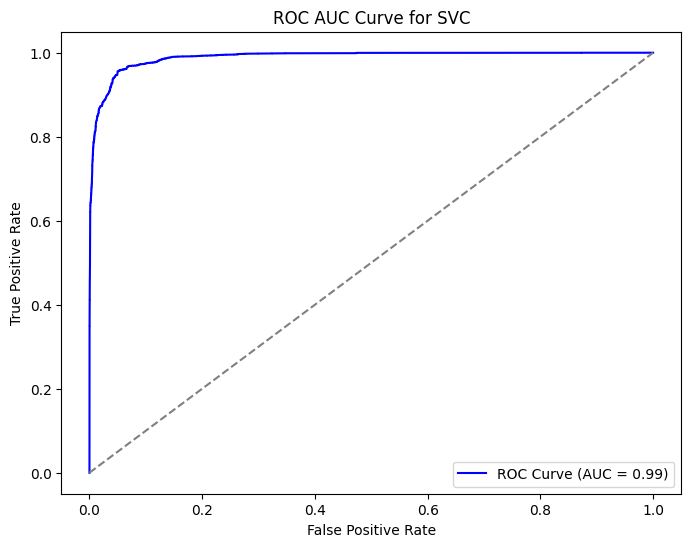

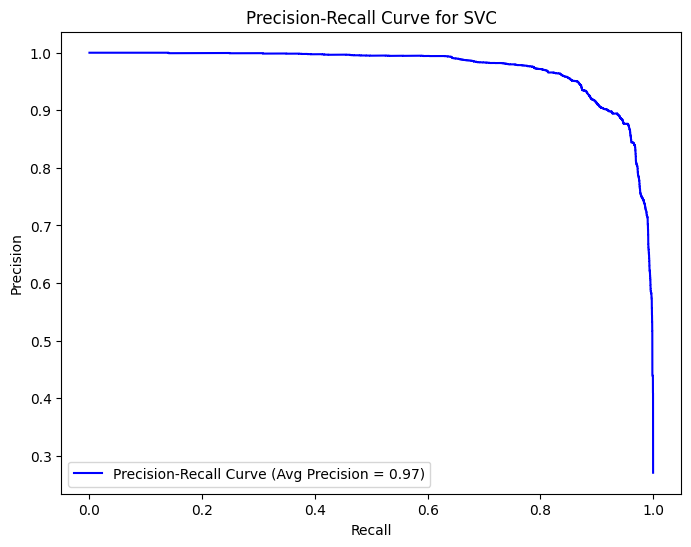

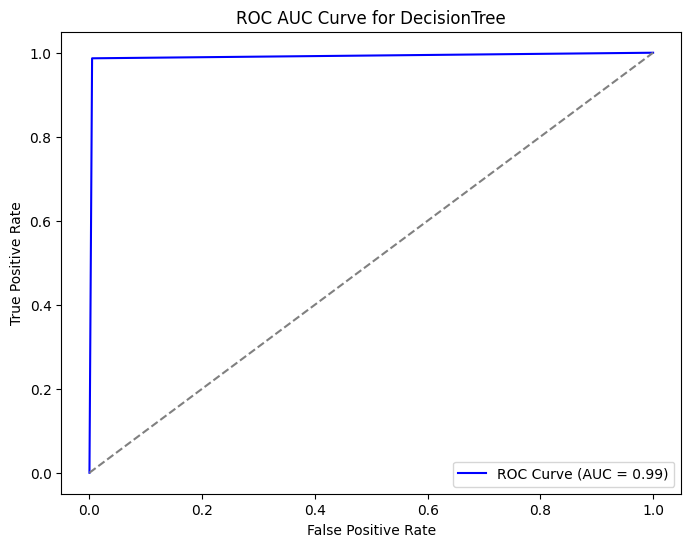

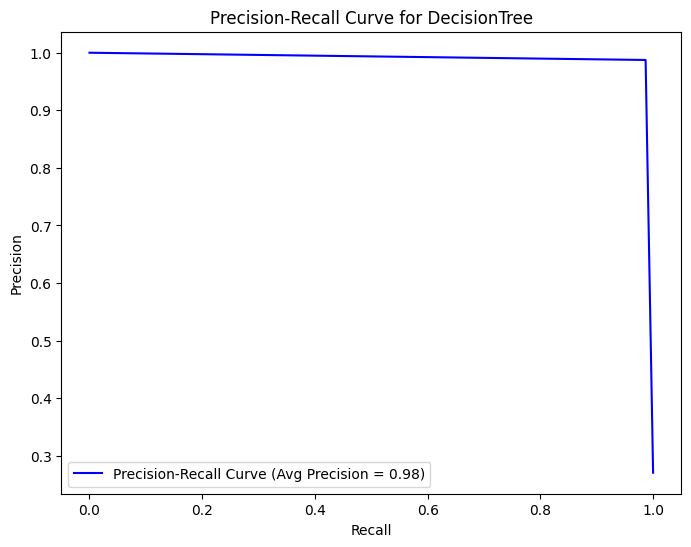

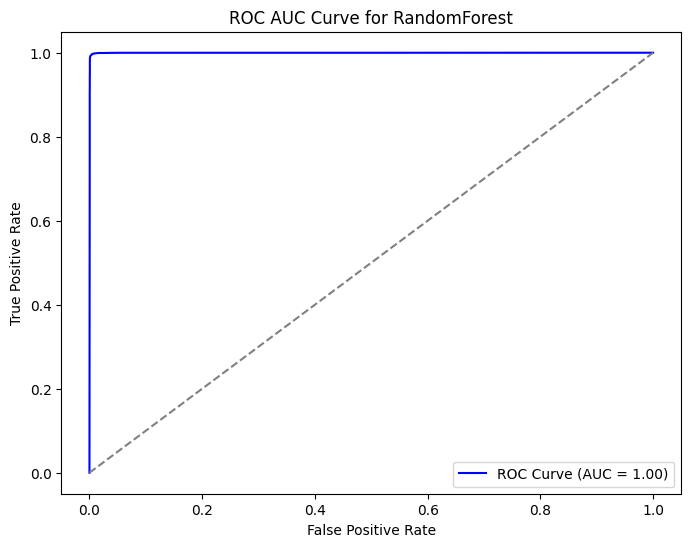

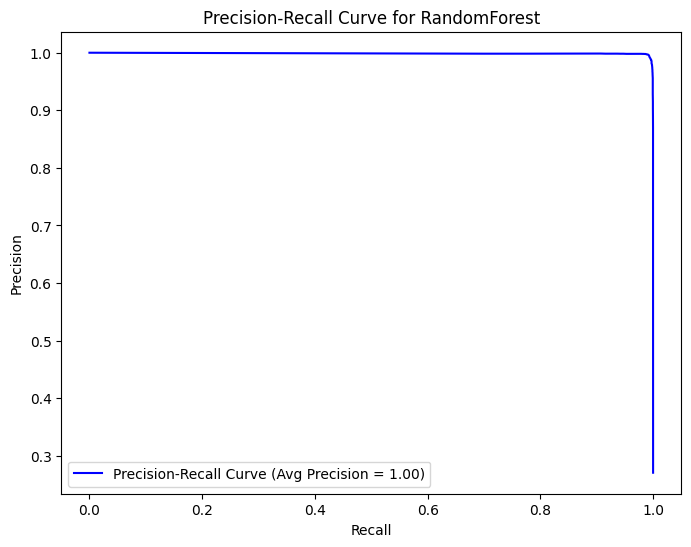

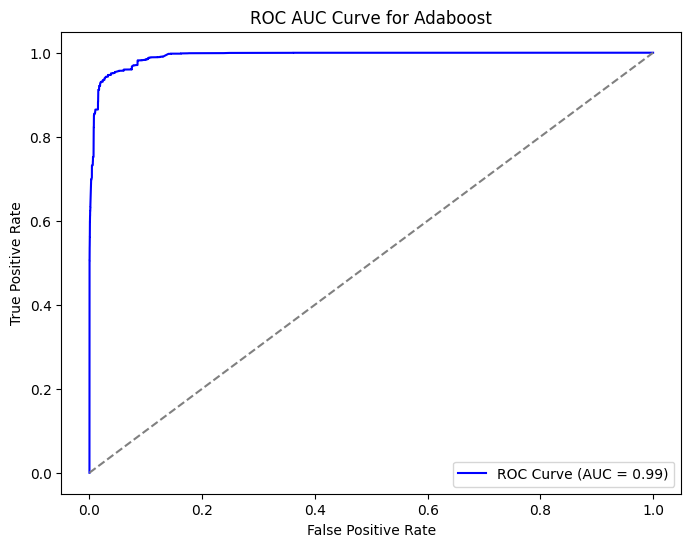

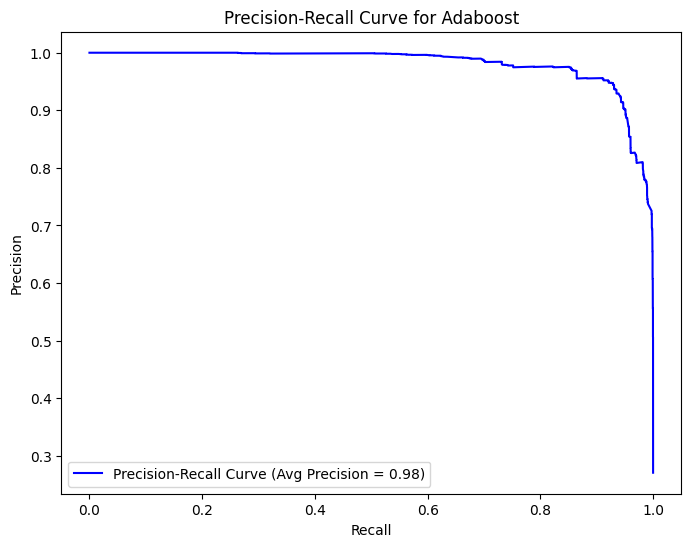

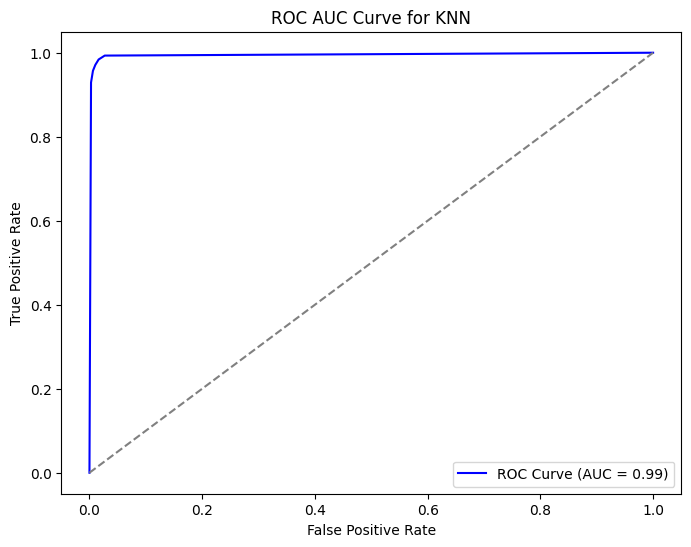

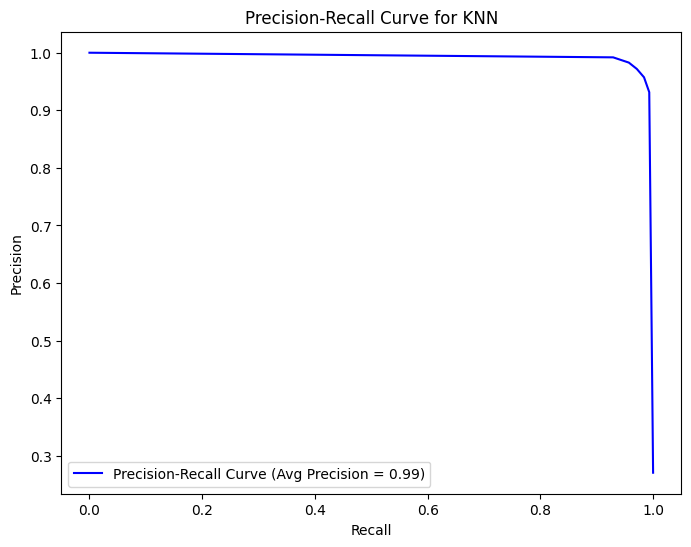

C:\Users\akash\anaconda3\envs\proj_env\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


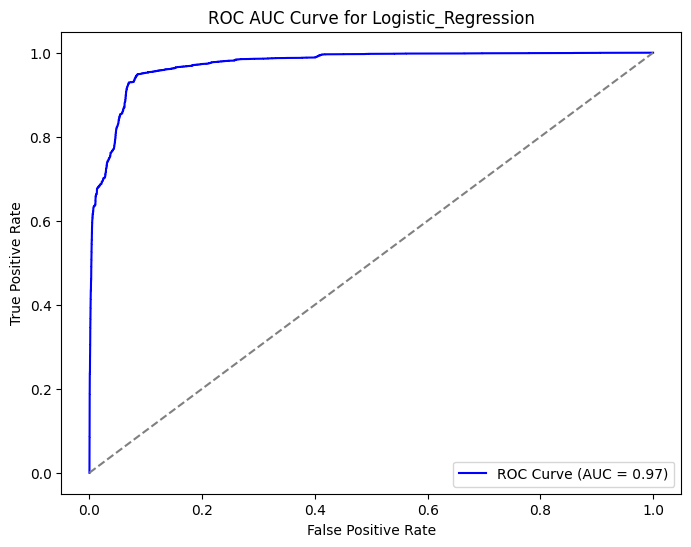

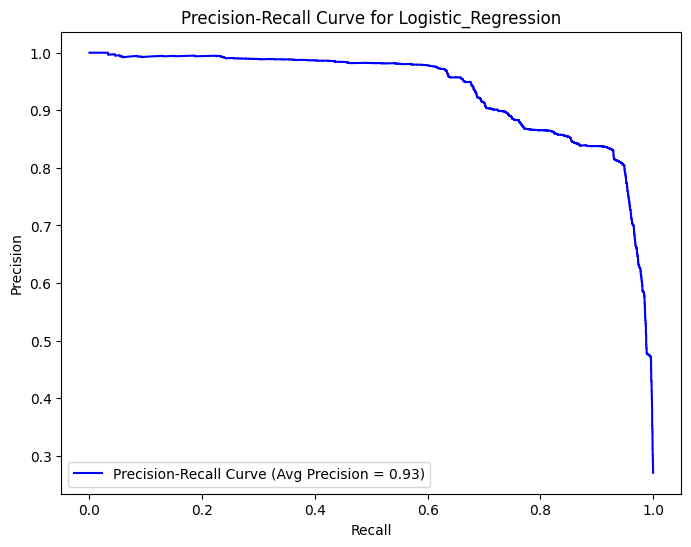

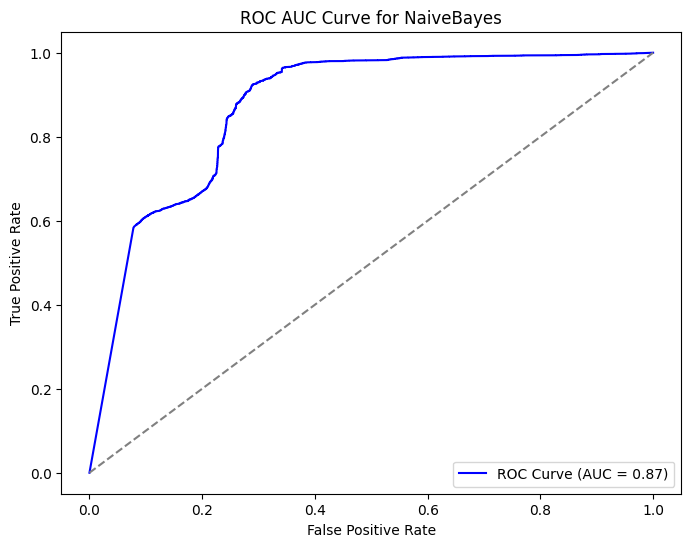

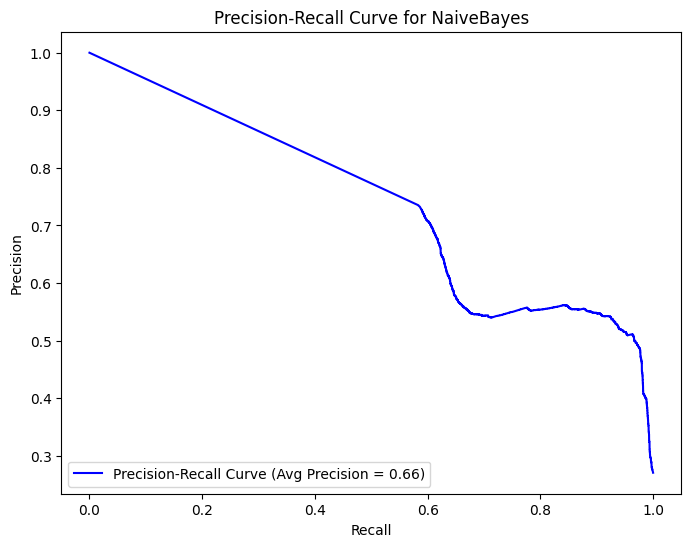

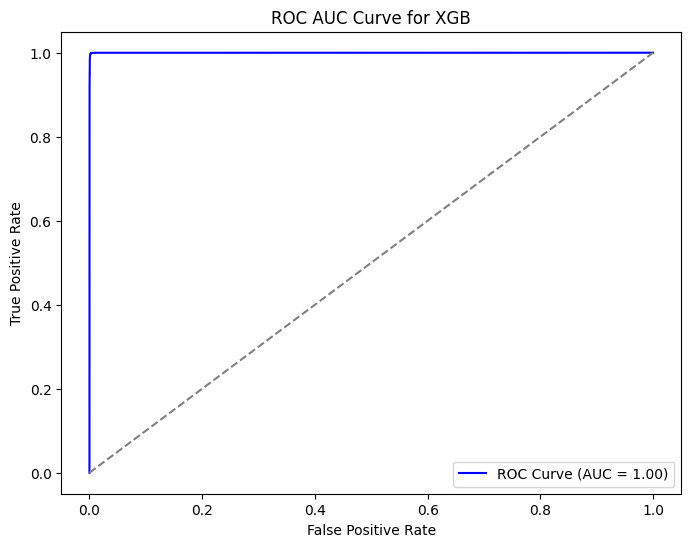

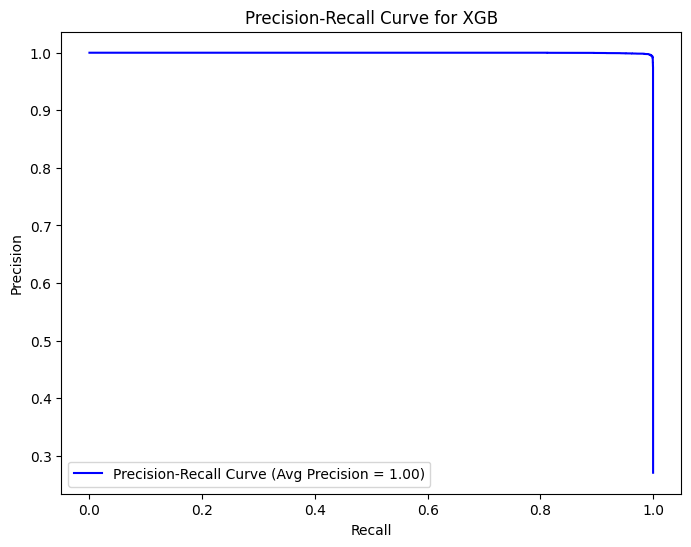

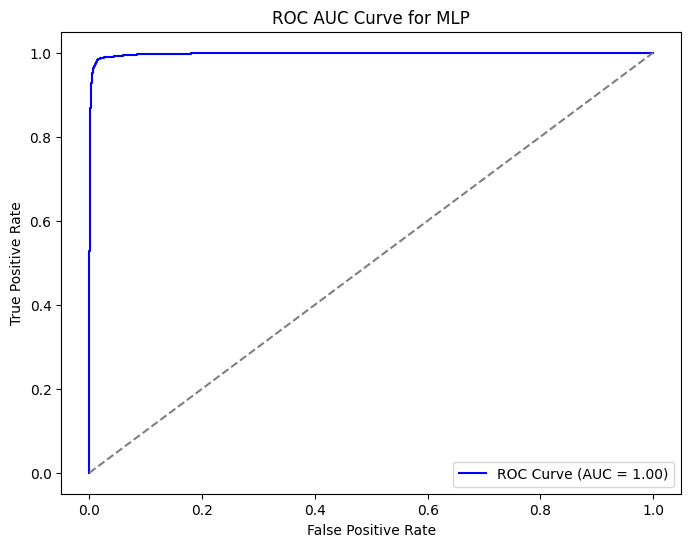

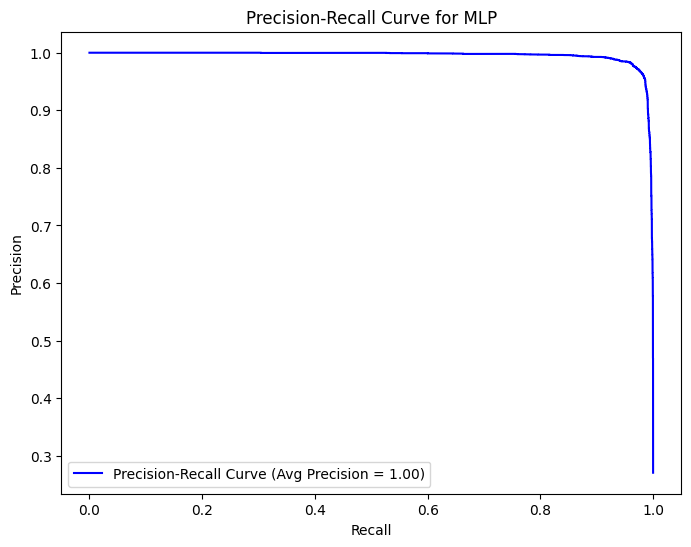

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 17369, number of negative: 46490
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14508
[LightGBM] [Info] Number of data points in the train set: 63859, number of used features: 66
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.271990 -> initscore=-0.984550
[LightGBM] [Info] Start training from score -0.984550


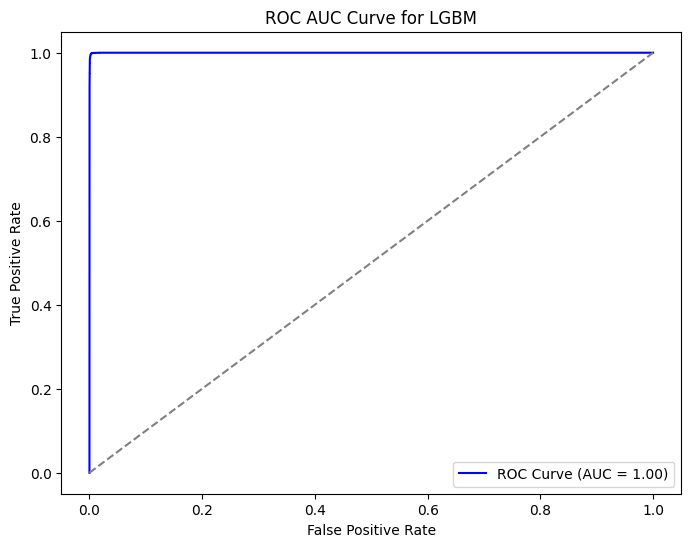

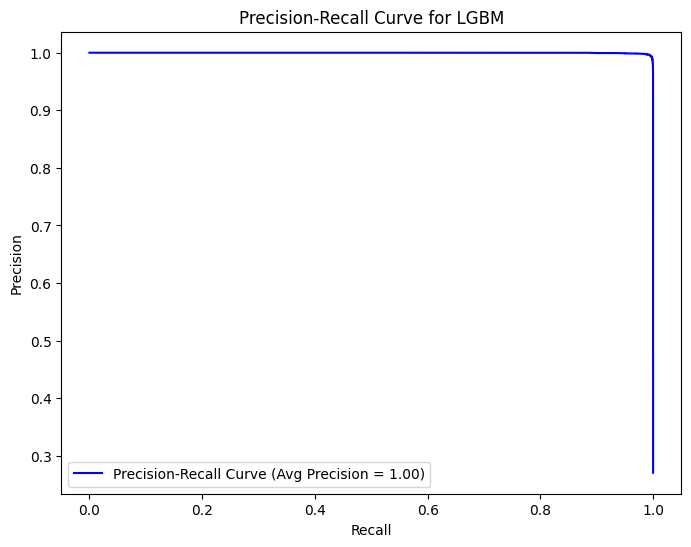

In [11]:
results = []
models = [{"SVC":SVC(probability=True,random_state=DEFAULT_RANDOM_SEED)},{"DecisionTree":DecisionTreeClassifier(random_state=DEFAULT_RANDOM_SEED)},{"RandomForest":RandomForestClassifier(random_state=DEFAULT_RANDOM_SEED)},{"Adaboost":AdaBoostClassifier(random_state=DEFAULT_RANDOM_SEED)},{"KNN":KNeighborsClassifier()},{"Logistic_Regression": LogisticRegression(random_state=DEFAULT_RANDOM_SEED)},{"NaiveBayes" : GaussianNB()},{"XGB" : XGBClassifier(random_state=DEFAULT_RANDOM_SEED)},{"MLP": MLPClassifier(random_state=DEFAULT_RANDOM_SEED)},{"LGBM":LGBMClassifier(random_state=DEFAULT_RANDOM_SEED)}]
for model_obj in models:
    for model_name, actual_model in model_obj.items():
        result = estimateResult(actual_model, X_train, y_train, X_test, y_test,model_name)
        results.append(result)

Plotting curves just to make sure model is not overfitting

In [12]:
non_para_results_df = pd.DataFrame(results)

non_para_results_df

,Model,Accuracy,Precision,Recall,F1 Score,False Positive Rate
0,SVC,0.950658,0.931917,0.881952,0.906246,0.023879
1,DecisionTree,0.993006,0.987410,0.986714,0.987062,0.004663
2,RandomForest,0.996566,0.994116,0.993180,0.993648,0.002179
3,Adaboost,0.964392,0.936208,0.931805,0.934001,0.023530
4,KNN,0.984581,0.971876,0.971076,0.971476,0.010414
5,Logistic_Regression,0.916672,0.862494,0.823045,0.842308,0.048630
6,NaiveBayes,0.758314,0.540302,0.711699,0.614268,0.224411
7,XGB,0.997902,0.994956,0.997296,0.996124,0.001874
8,MLP,0.984867,0.972683,0.971311,0.971997,0.010109
9,LGBM,0.997361,0.993438,0.996825,0.995129,0.002440


In [13]:
# Save results to CSV
non_para_results_df.to_csv('normal_model_results.csv', index=False)

<h2>Hyper parameter tuning </h2>

In [14]:
param_by_model = [
    {
        'model':{
            'model_name': 'XGB',
            'actual_model': XGBClassifier(random_state=DEFAULT_RANDOM_SEED)
        },
        'param_grid' : {
    'n_estimators': [50, 100]}
    },
    {
    'model':{
        'model_name': 'SVC',
        'actual_model': SVC(probability=True,random_state=DEFAULT_RANDOM_SEED)
    },
    'param_grid' : {
    'C': [0.1, 1, 10]}
    },
    {
        'model':{
            'model_name' : 'KNN',
            'actual_model':KNeighborsClassifier()
        },
        'param_grid' : {
    'n_neighbors': [3, 5, 7]}
    },
    {
        'model':{
            'model_name': 'LGBM',
            'actual_model': LGBMClassifier(random_state=DEFAULT_RANDOM_SEED)
        },
        'param_grid' : {
    'n_estimators': [50, 100]}
    },
    {
        'model':{
            'model_name': 'Adaboost',
            'actual_model':AdaBoostClassifier(random_state=DEFAULT_RANDOM_SEED)
        },
        'param_grid' : {
    'n_estimators': [50, 100]}
    },
    {
        'model':{
            'model_name': 'Logistic Regression',
            'actual_model': LogisticRegression(random_state=DEFAULT_RANDOM_SEED)
        },
        'param_grid' : {
    'penalty': ['l1', 'l2', 'elasticnet']}
    },
    {
        'model': {
            'model_name': 'Decision Tree',
            'actual_model': DecisionTreeClassifier(random_state=DEFAULT_RANDOM_SEED)
        },
        'param_grid' : {
    'max_depth': [5, 10, None]}
    },
    {
        'model':{
            'model_name' : 'Random Forest',
            'actual_model': RandomForestClassifier(random_state=DEFAULT_RANDOM_SEED)
        },
        'param_grid' : {
    'n_estimators': [50, 100], 'max_depth': [10, None]}
    },
    {
        'model':{
            'model_name': 'MLP',
            'actual_model': MLPClassifier(random_state=DEFAULT_RANDOM_SEED)
        },
        'param_grid' : {
    'hidden_layer_sizes': [(50,), (100,)]}
    }]

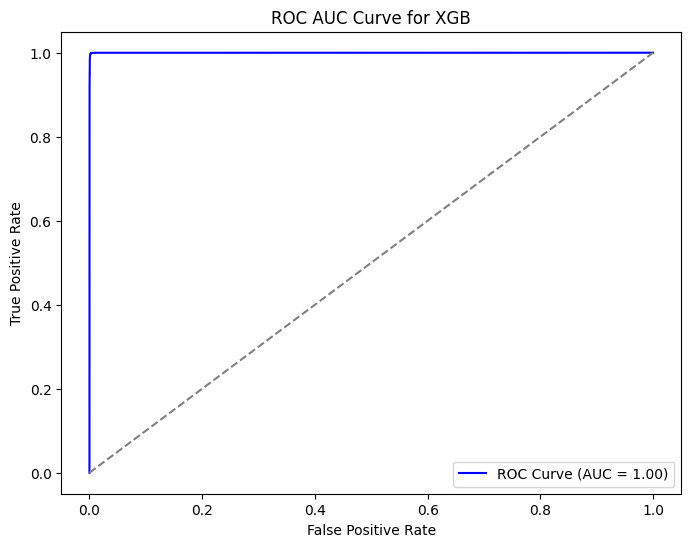

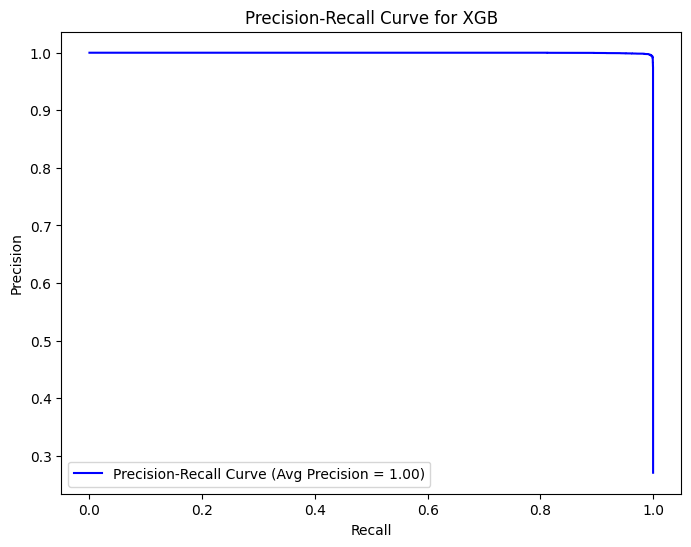

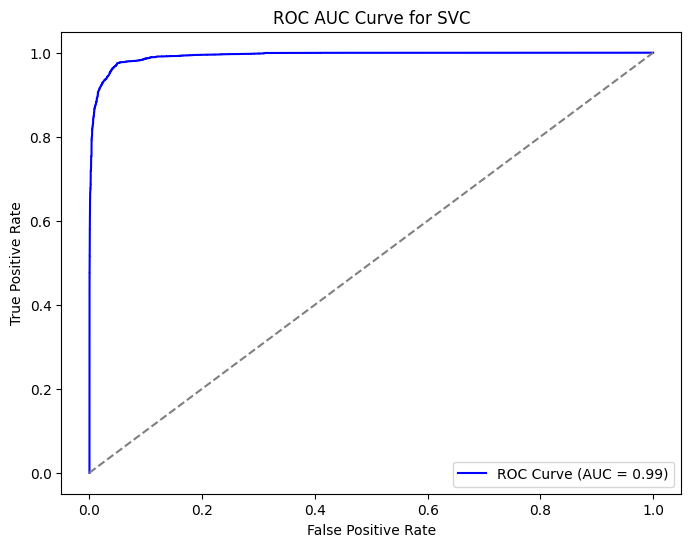

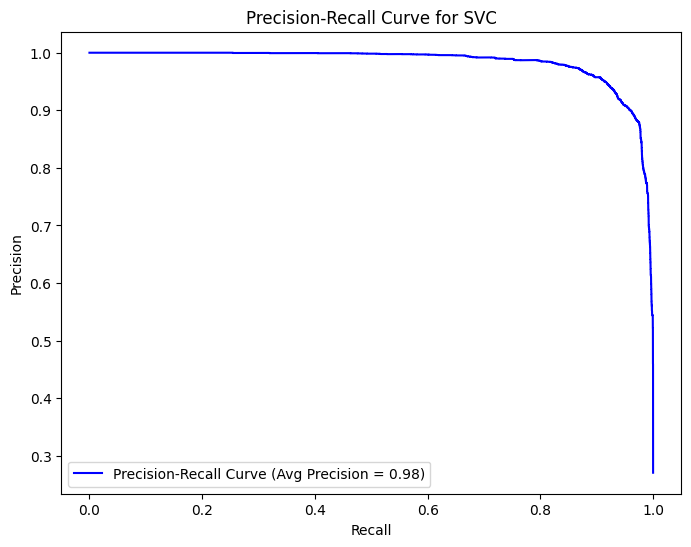

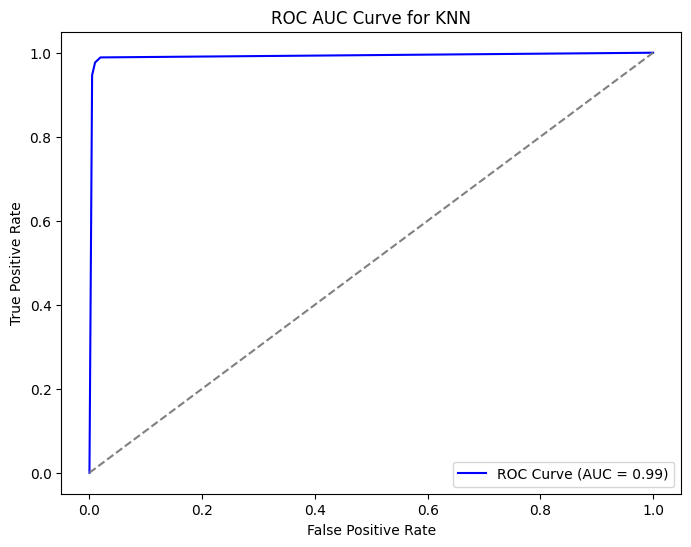

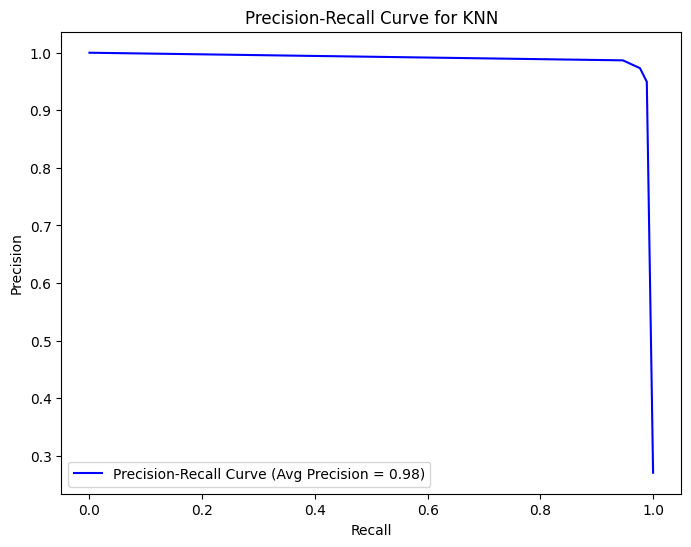

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 17369, number of negative: 46490
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14508
[LightGBM] [Info] Number of data points in the train set: 63859, number of used features: 66
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.271990 -> initscore=-0.984550
[LightGBM] [Info] Start training from score -0.984550
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 17369, number of negative: 46490
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011012 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14508
[LightGBM] [Info] Number of data points in the train set: 63859, number of us

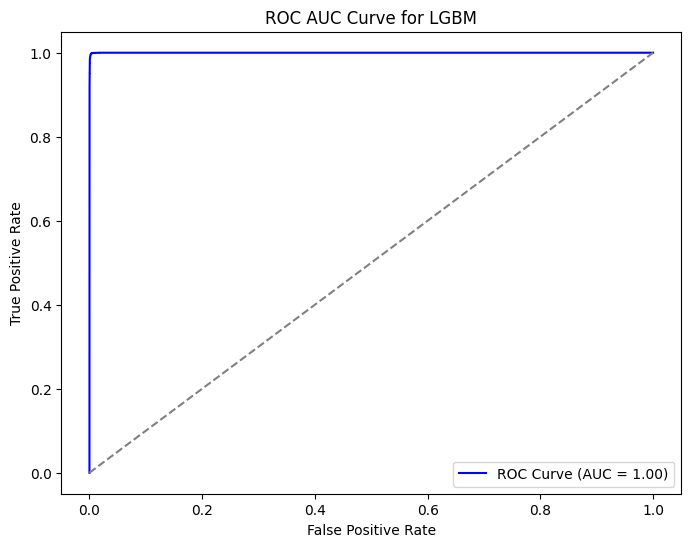

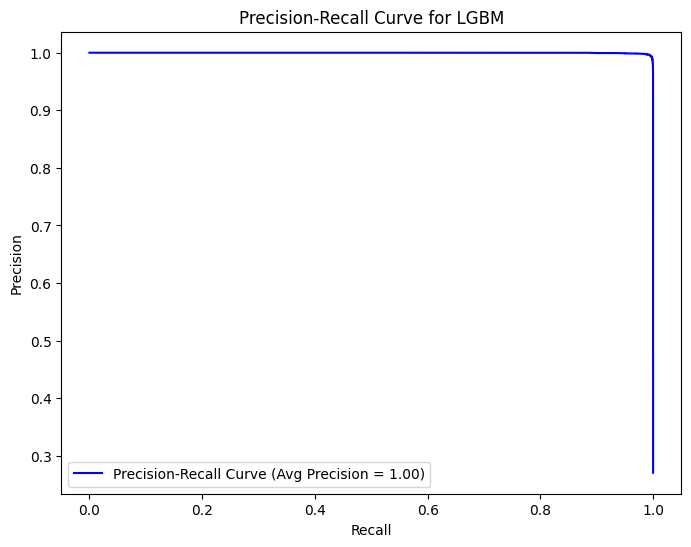

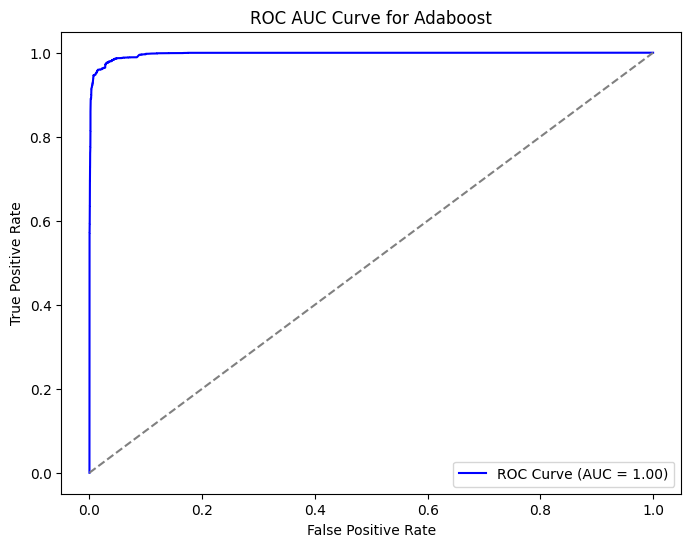

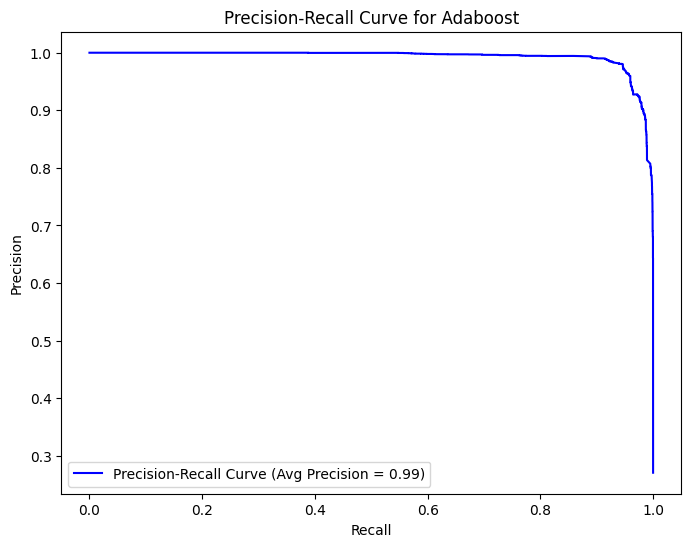

C:\Users\akash\anaconda3\envs\proj_env\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
10 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\akash\anaconda3\envs\proj_env\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\akash\anaconda3\envs\proj_env\lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\akash\anaconda3\envs\proj_env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1193, in fit
    solve

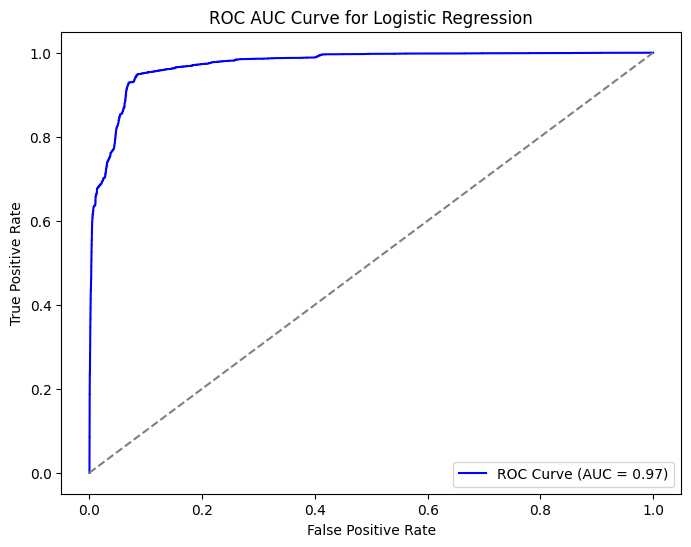

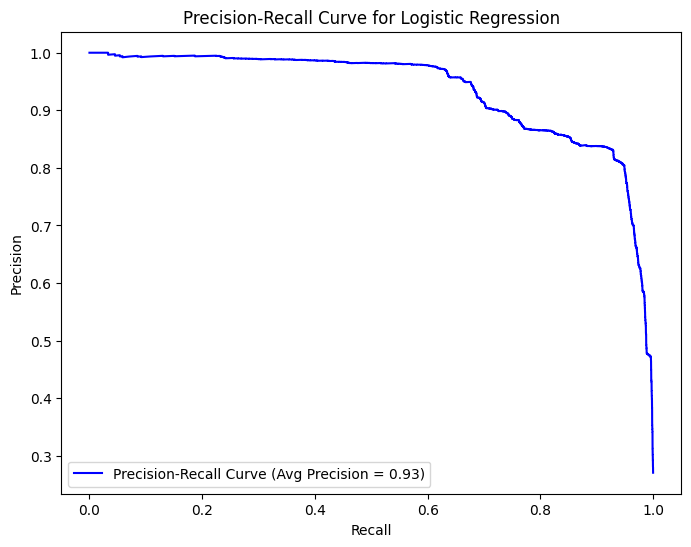

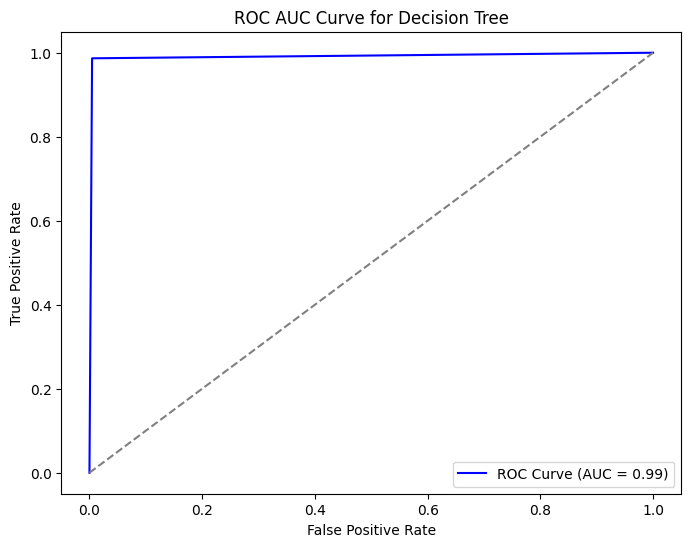

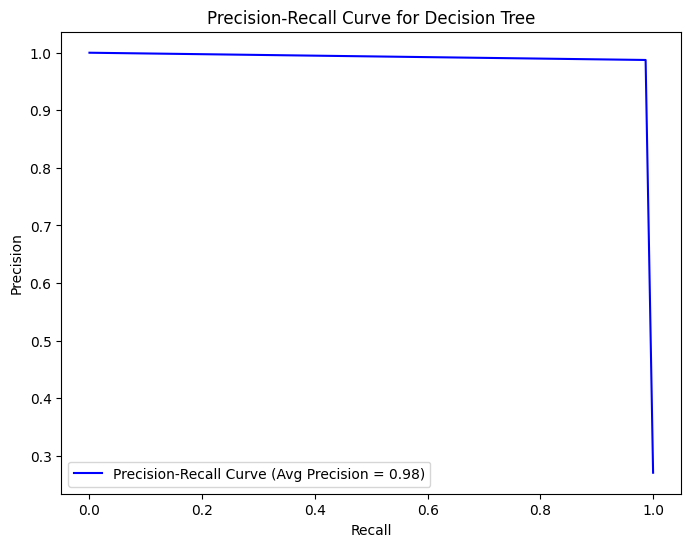

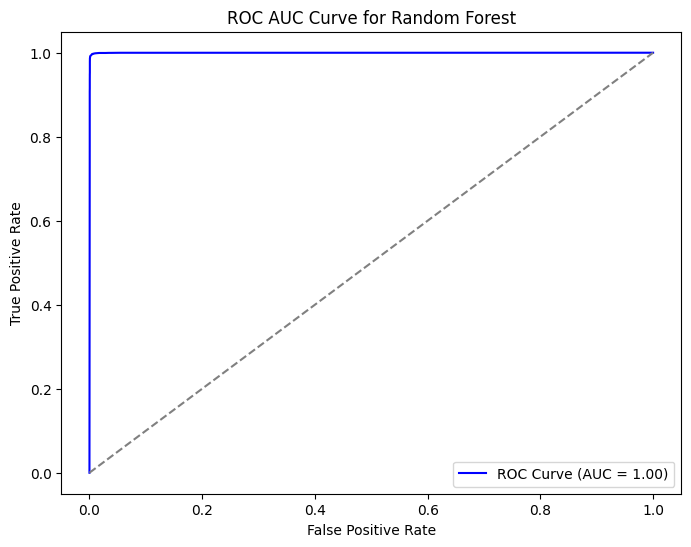

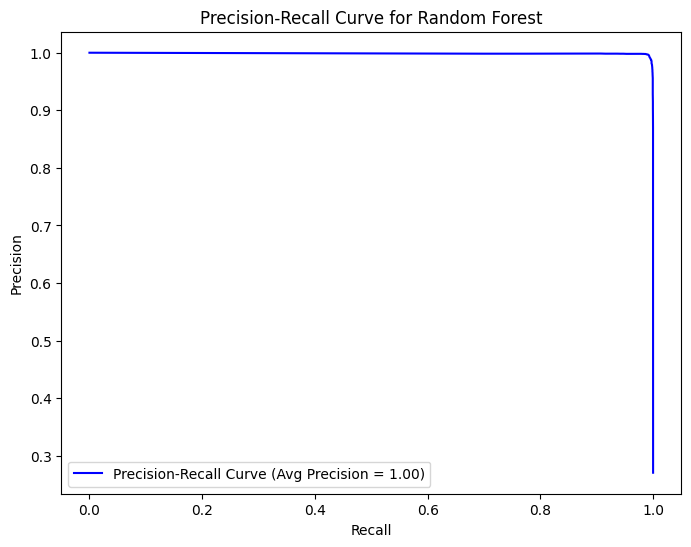

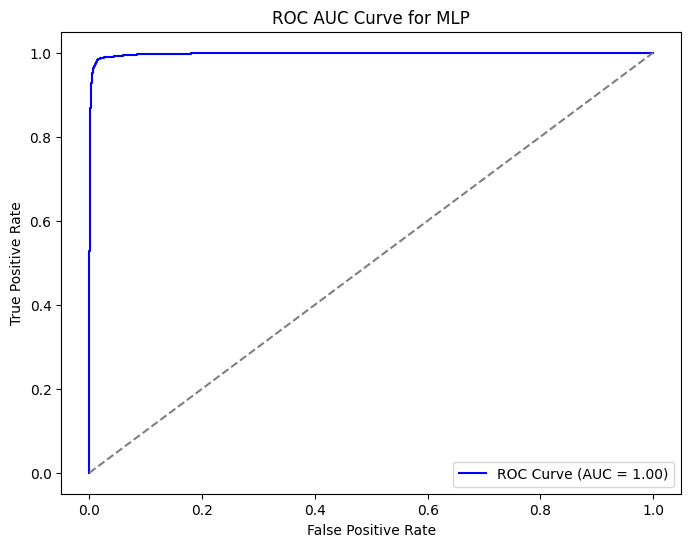

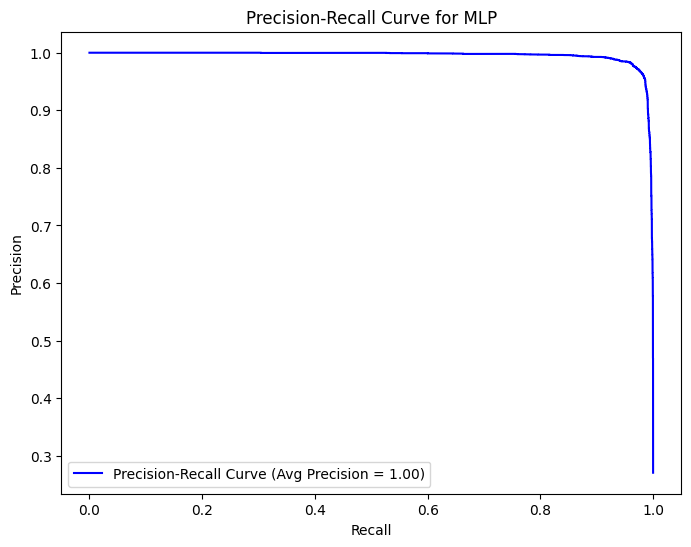

In [15]:
hyper_results = []
best_params = {}
for param in param_by_model:
    model_name = param['model']['model_name']
    actual_model = param['model']['actual_model']
    param_grid = param['param_grid']
    grid_search = GridSearchCV(actual_model, param_grid, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    best_params[model_name] = grid_search.best_params_
    result = estimateResult(best_model, X_train, y_train, X_test, y_test,model_name)
    hyper_results.append(result)
    # Save trained model
    joblib.dump(best_model, f'{model_name.replace(" ", "_")}_model.pkl')

Plotting curves just to make sure model is not overfitting

In [16]:
hyperparam_results_df = pd.DataFrame(hyper_results)

In [17]:
# Display results
display(hyperparam_results_df)

,Model,Accuracy,Precision,Recall,F1 Score,False Positive Rate
0,XGB,0.997902,0.994956,0.997296,0.996124,0.001874
1,SVC,0.963947,0.949616,0.915226,0.932104,0.017996
2,KNN,0.986425,0.973172,0.976720,0.974943,0.009979
3,LGBM,0.997361,0.993438,0.996825,0.995129,0.002440
4,Adaboost,0.978763,0.973764,0.946972,0.960181,0.009456
5,Logistic Regression,0.916672,0.862494,0.823045,0.842308,0.048630
6,Decision Tree,0.993006,0.987410,0.986714,0.987062,0.004663
7,Random Forest,0.996566,0.994116,0.993180,0.993648,0.002179
8,MLP,0.984867,0.972683,0.971311,0.971997,0.010109


Results don't vary much from non parameterized results

In [18]:
# Save results to CSV
hyperparam_results_df.to_csv('hyper_model_results.csv', index=False)

In [19]:
# Save best hyperparameters to a file
best_params_df = pd.DataFrame(list(best_params.items()), columns=['Model', 'Best Parameters'])
best_params_df.to_csv('best_hyperparameters.csv')

In [20]:
display(best_params_df)

,Model,Best Parameters
0,XGB,{'n_estimators': 100}
1,SVC,{'C': 10}
2,KNN,{'n_neighbors': 3}
3,LGBM,{'n_estimators': 100}
4,Adaboost,{'n_estimators': 100}
5,Logistic Regression,{'penalty': 'l2'}
6,Decision Tree,{'max_depth': None}
7,Random Forest,"{'max_depth': None, 'n_estimators': 100}"
8,MLP,"{'hidden_layer_sizes': (100,)}"
